## Install Dependencies


### torch, torchvision

In [1]:
# install torch and torchvision
!pip3 install torch torchvision torchaudio torchtext --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


### pytorch3d

In [2]:
import os
import torch

try:
    import pytorch3d
except ModuleNotFoundError:
    !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    !tar xzf 1.10.0.tar.gz
    os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    !pip install git+https://github.com/facebookresearch/pytorch3d.git

In [3]:
import pytorch3d
pytorch3d.__version__

'0.7.1'

### SMPL / Meshes

In [4]:
!pip install smplpytorch
!pip install chumpy
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gr8lmdr_
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-gr8lmdr_


### GPU

In [6]:
import torch

torch.cuda.is_available()

False

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [8]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cpu')

### Import the GitHub Project

In [9]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 670, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 670 (delta 24), reused 30 (delta 13), pack-reused 622
Receiving objects: 100% (670/670), 67.54 MiB | 22.01 MiB/s, done.
Resolving deltas: 100% (392/392), done.


### Local Imports 

In [10]:
from project.aux_functions import *

from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipwrapper import CLIPwrapper

from project.optimization import OptimEnv, init_weights
from project.model import compose, SimpledCLIPContext

import trimesh

import clip

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.8/dist-packages/smplpytorch/pytorch/smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


### SMPL

In [11]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
colored_reference_SMPL = trimesh.load("project/SMPL_female_with_colors.obj", process=False)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(vert,faces):
  return txfactory.from_image(colored_reference_SMPL ,vert,faces )
# pose and shape initalization
pose_vect = torch.zeros((1, 72), device=dev) # theta, used in optimization
shape_vect = torch.ones((1, 10), device=dev) # beta, not used in optimization
# create the smpl model
smpl_model = SMPLwrapper(model=None, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
mesh = smpl_model.mesh(theta=pose_vect, beta=shape_vect)

### Differentiable Renderer

In [12]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# create a camera using the cameras factory
camera = camsfactory.fov_persp_scs(coords=(2.25, 0, 3), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=camera)
# render the textured mesh generated by SMPL
image = renderer.render(mesh)

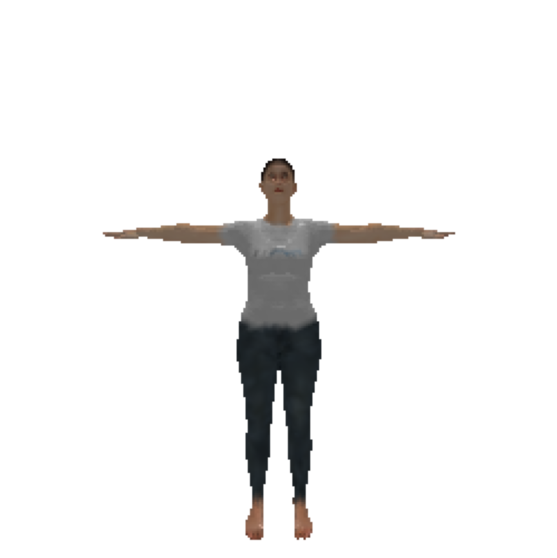

In [13]:
# a quick visualization of the rendered mesh
plot_image_t(image);

### CLIP

In [14]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [15]:
clip_model = CLIPwrapper(model_name="ViT-B/32", device=dev)

In [39]:
# a prompt describing the previous image
with torch.no_grad():
  print(cos_dist(clip_model.img_emb(image), clip_model.pmt_emb("""
  a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands apart and at the shoulder level.""")).item())

0.26552149653434753


### MODELS


In [40]:
# create a model factory
model_context = SimpledCLIPContext(smpl_model, renderer, clip_model) 
MODELS = {
    "P1": model_context.create(
        prompt="""a white human wearing a light grey T-shirt and blue pants, standing up on her straight feet. She is looking upfront with both hands up.""")
    }

In [19]:
def run_optimization(model, n_passes=1000):
  pose, shape = init_weights(device=dev) # weights used in optimization
  optim_config = {
      "lr": 1e-3,
      "betas": (0.9, 0.999),
      "sch_factor": 0.5,
      "sch_patience": 5,
      "sch_threshold": 1e-3,
      "sch_cooldown": 50,
      "sch_verbose": True
  }
  optimenv = OptimEnv(model=model, weights=[pose, shape], activate_lr_sch=True, config=optim_config)
  result = optimenv.optimize(pose=pose, shape=shape, n_passes=n_passes, tracker_settings={"loss":{"interleaving": 10}, "pose": {"interleaving": 100}, "shape": {"interleaving": 100}})
  return result

def intermediate_views(result, coords):
  camera = camsfactory.fov_persp_scs(coords=coords, fov=60, frustrum_depth=(1, 100))
  renderer = Renderer(device=dev, cameras=camera)
  pose_shape = zip(result["tracked"]["poses"]["pose"], result["tracked"]["shapes"]["shape"])
  for pose, shape in pose_shape:
    pose, shape = pose.to(dev), shape.to(dev)
    mesh = smpl_model.mesh(theta=pose, beta=shape)
    image = renderer.render(mesh)
    plot_image_t(image)

In [ ]:
result = run_optimization(MODELS["P1"])

In [ ]:
plot_losses(result["tracked"]["losses"])

In [ ]:
intermediate_views(result, coords=(2.25, 0, 3))

In [ ]:
result2 = run_optimization(MODELS["P1"], n_passes=500)

In [ ]:
plot_losses(result2["tracked"]["losses"])

In [ ]:
intermediate_views(result2, coords=(2.25, 0, 3))